# Crop Disease Detection Inference Notebook

This notebook demonstrates how to use the trained YOLOv8 model for crop disease detection.

## 1. Setup

In [32]:
# Import libraries
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [33]:
# Configuration
MODEL_PATH = './runs/classify/tobacco_disease_classification/weights/best.pt'
CONFIDENCE_THRESHOLD = 0.25

# Disease class names
CLASS_NAMES = {
    0: 'healthy',
    1: 'alternaria',
    2: 'cercospora',
    3: 'mosaic_virus',
    4: 'bacterial_spot',
    5: 'early_blight',
    6: 'late_blight'
}

print(f"Model path: {MODEL_PATH}")
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"Disease classes: {list(CLASS_NAMES.values())}")

Model path: ./runs/classify/tobacco_disease_classification/weights/best.pt
Confidence threshold: 0.25
Disease classes: ['healthy', 'alternaria', 'cercospora', 'mosaic_virus', 'bacterial_spot', 'early_blight', 'late_blight']


## 2. Load Model

In [34]:
# Load trained model
model = YOLO(MODEL_PATH)

print("✓ Model loaded successfully")
print(f"Model: {MODEL_PATH}")

✓ Model loaded successfully
Model: ./runs/classify/tobacco_disease_classification/weights/best.pt


## 3. Single Image Detection

In [35]:
def classify_disease(image_path, model):
    results = model.predict(image_path)

    # Extract class probabilities
    probs = results[0].probs.data.cpu().numpy()
    class_id = probs.argmax()
    confidence = probs[class_id]

    primary_disease = results[0].names[class_id]

    # Load annotated image
    annotated = results[0].plot()
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    return {
        "image_path": image_path,
        "primary_disease": primary_disease,
        "primary_confidence": float(confidence),
        "probabilities": {
            cls: float(probs[i])
            for i, cls in results[0].names.items()
        },
        "annotated_image": annotated
    }



image 1/1 /Users/dominicmushayi/Documents/Capstone /Project/backend/disease_detection/dataset/valid/cercospora nicotianae/1-cercosporiose-2_jpg.rf.db3064aeb36a27b2e3020bc26c810edd.jpg: 224x224 cercospora nicotianae 1.00, alternaria alternata 0.00, no cercospora nicotianae or alternaria alternata present 0.00, 17.1ms
Speed: 13.1ms preprocess, 17.1ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)

CLASSIFICATION RESULTS
Image: ./dataset/valid/cercospora nicotianae/1-cercosporiose-2_jpg.rf.db3064aeb36a27b2e3020bc26c810edd.jpg
Primary Disease: cercospora nicotianae
Confidence: 100.00%

Class Probabilities:
  alternaria alternata: 0.00%
  cercospora nicotianae: 100.00%
  no cercospora nicotianae or alternaria alternata present: 0.00%


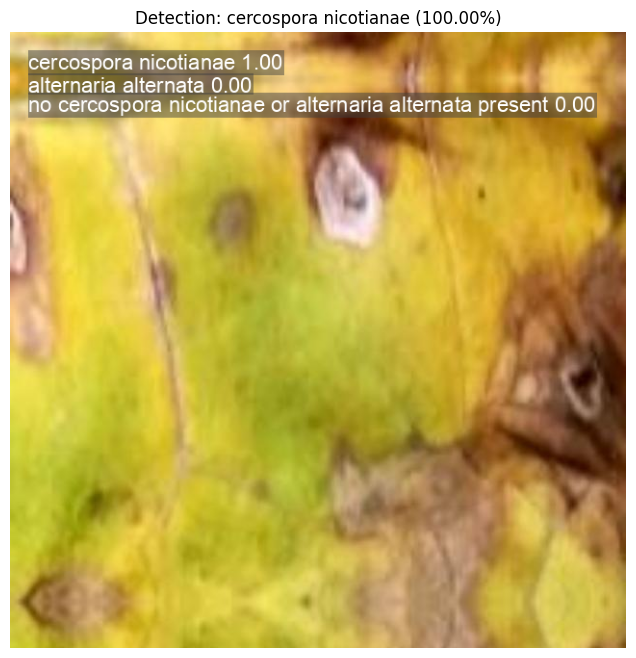

In [36]:
# Test on a single image
TEST_IMAGE = './dataset/valid/cercospora nicotianae/1-cercosporiose-2_jpg.rf.db3064aeb36a27b2e3020bc26c810edd.jpg'  # Change this to your test image

# Run detection
result = classify_disease(TEST_IMAGE, model)

# Display results
print("\n" + "="*60)
print("CLASSIFICATION RESULTS")
print("="*60)
print(f"Image: {result['image_path']}")
print(f"Primary Disease: {result['primary_disease']}")
print(f"Confidence: {result['primary_confidence']:.2%}")
print("\nClass Probabilities:")

for cls, prob in result["probabilities"].items():
    print(f"  {cls}: {prob:.2%}")

print("="*60)


# Display annotated image
plt.figure(figsize=(12, 8))
plt.imshow(result['annotated_image'])
plt.title(f"Detection: {result['primary_disease']} ({result['primary_confidence']:.2%})")
plt.axis('off')
plt.show()

## 4. Batch Detection

In [37]:
from pathlib import Path

IMAGE_DIR = './dataset/valid/'
NUM_SAMPLES = 6

# Get sample images (recursive search)
image_files = list(Path(IMAGE_DIR).rglob('*.jpg'))[:NUM_SAMPLES]

# Run classification on selected images
all_results = []
for img_path in image_files:
    result = classify_disease(str(img_path), model)
    all_results.append(result)

print(f"✓ Processed {len(all_results)} images")



image 1/1 /Users/dominicmushayi/Documents/Capstone /Project/backend/disease_detection/dataset/valid/alternaria alternata/1524158_jpg.rf.42431c6c7695714be38604024efb3661.jpg: 224x224 alternaria alternata 1.00, cercospora nicotianae 0.00, no cercospora nicotianae or alternaria alternata present 0.00, 4.7ms
Speed: 2.3ms preprocess, 4.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/dominicmushayi/Documents/Capstone /Project/backend/disease_detection/dataset/valid/alternaria alternata/tabac267_jpg.rf.25d2c10c0c5c56cc65a6ee4f64417a2c.jpg: 224x224 alternaria alternata 0.99, no cercospora nicotianae or alternaria alternata present 0.01, cercospora nicotianae 0.00, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/dominicmushayi/Documents/Capstone /Project/backend/disease_detection/dataset/valid/alternaria alternata/Alternaria-Zimbabwe1_jpg.rf.0c45edde66a5ffe638cee4f8b025715d.jpg: 224x2

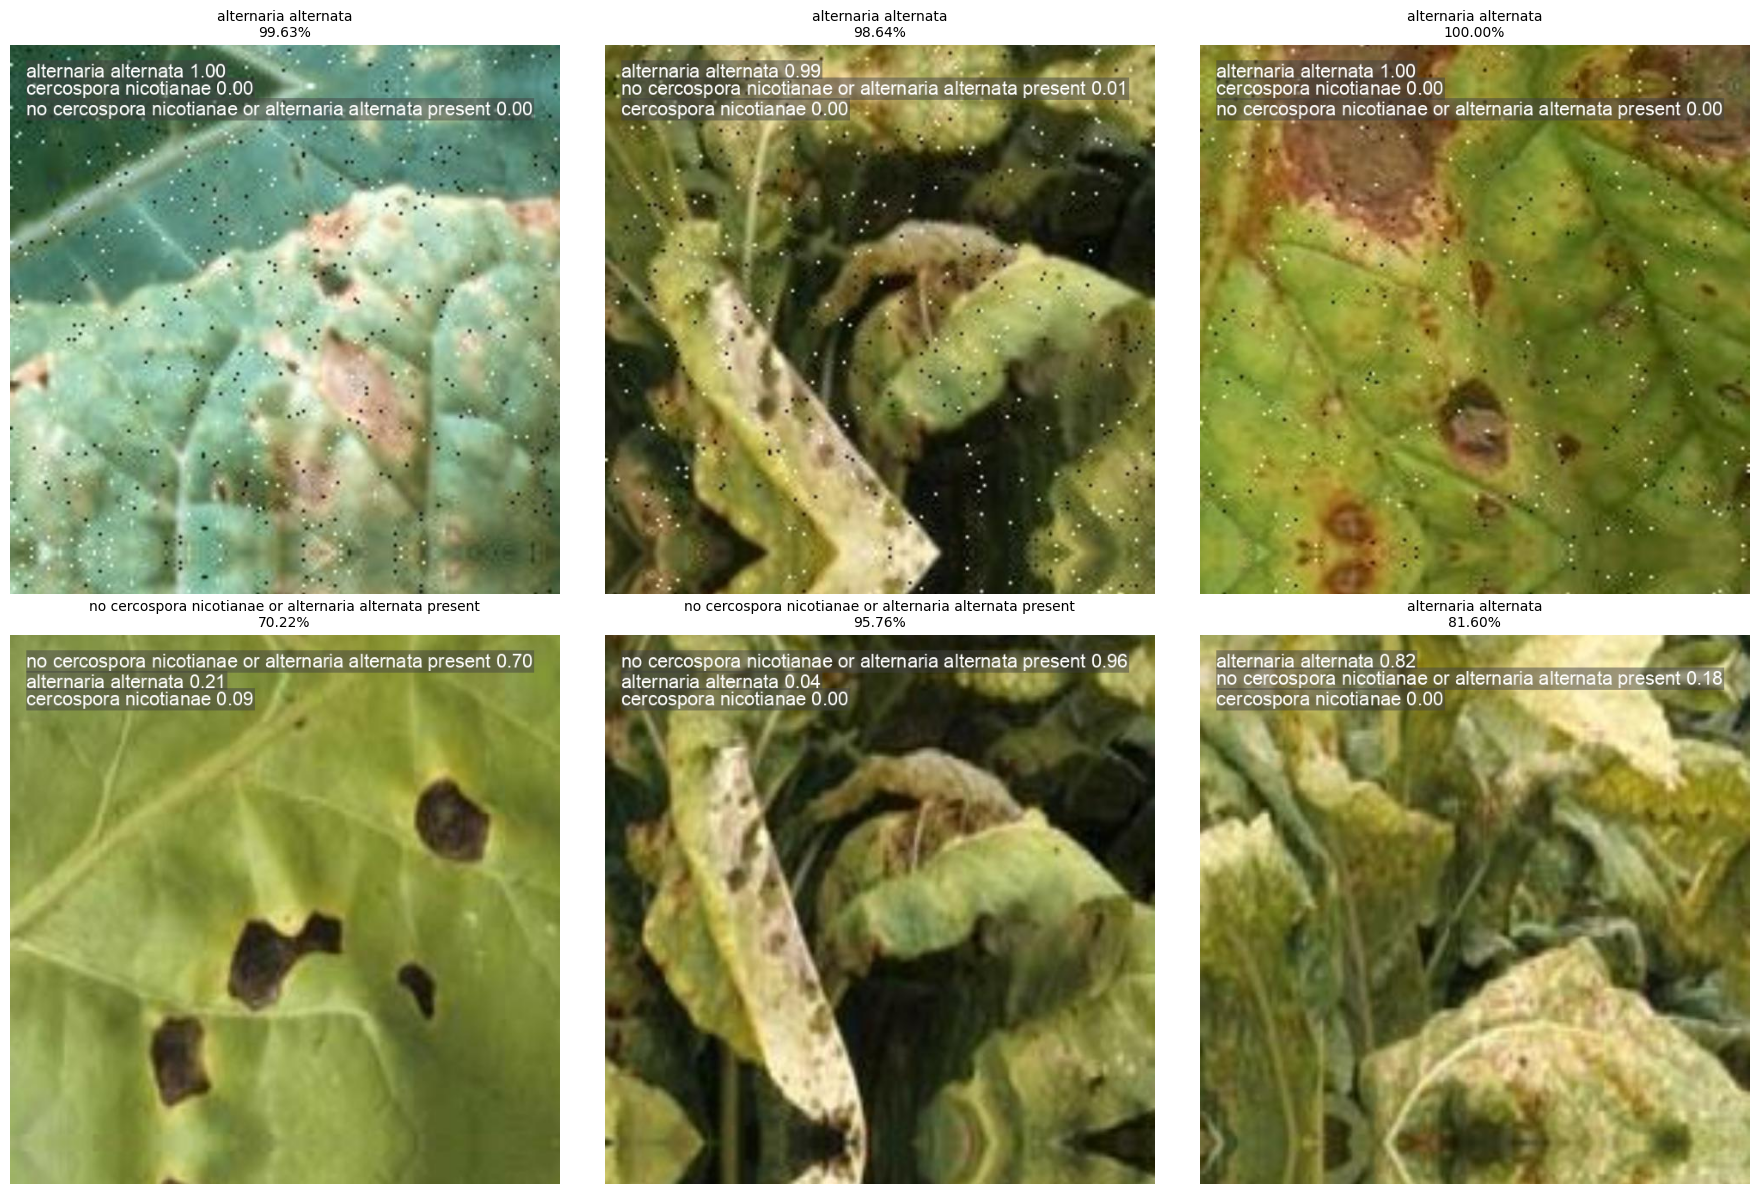

In [38]:
# Visualize batch results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, result in enumerate(all_results):
    axes[idx].imshow(result['annotated_image'])
    title = f"{result['primary_disease']}\n{result['primary_confidence']:.2%}"
    axes[idx].set_title(title, fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 5. Statistics and Summary

In [39]:
# Total images
total_images = len(all_results)

# Count each disease
disease_counts = {}
for result in all_results:
    disease = result['primary_disease']
    disease_counts[disease] = disease_counts.get(disease, 0) + 1

# Print summary
print("\n" + "="*60)
print("BATCH CLASSIFICATION SUMMARY")
print("="*60)
print(f"Total Images: {total_images}")
print("\nDisease Distribution:")
for disease, count in sorted(disease_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = count / total_images * 100
    print(f"  {disease}: {count} ({percentage:.1f}%)")
print("="*60)



BATCH CLASSIFICATION SUMMARY
Total Images: 6

Disease Distribution:
  alternaria alternata: 4 (66.7%)
  no cercospora nicotianae or alternaria alternata present: 2 (33.3%)


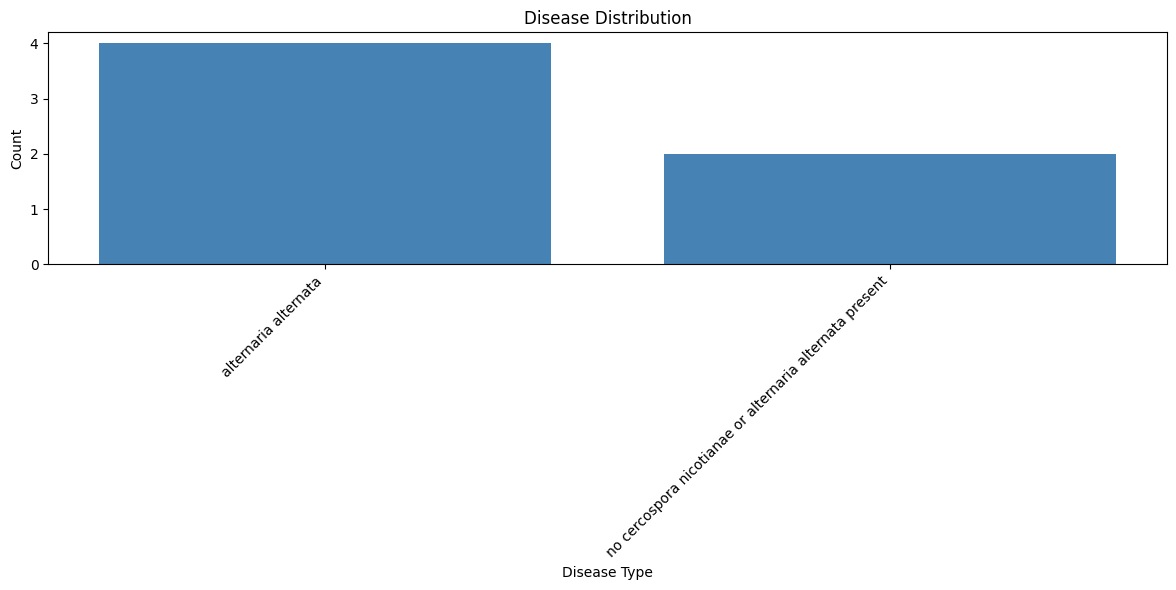

In [40]:
# Visualize disease distribution
if disease_counts:
    diseases = list(disease_counts.keys())
    counts = list(disease_counts.values())
    
    plt.figure(figsize=(12, 6))
    plt.bar(diseases, counts, color='steelblue')
    plt.xlabel('Disease Type')
    plt.ylabel('Count')
    plt.title('Disease Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()